### Quick analysys of the generated data
Below we define some popular analytical functions for analysis of the generated images, compared to the original ones. 

In [15]:
## Necessary imports
import os
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
from scipy.ndimage import gaussian_filter
from scipy.linalg import sqrtm

import glob
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.models import inception_v3, Inception_V3_Weights

In [9]:
# Ensure notebook sees necessary paths
import os, sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

Simple Analysis functions definitions.

In [8]:
def compute_pixel_stats(image_path):
    img = np.array(Image.open(image_path))
    stats = {}
    if img.ndim == 3:
        for i, c in enumerate(['R','G','B']):
            stats[f'mean_{c}'] = img[:,:,i].mean()
            stats[f'std_{c}'] = img[:,:,i].std()
    else:
        stats['mean'] = img.mean()
        stats['std'] = img.std()
    return stats

def compute_noise(image_path, sigma=1):
    img = Image.open(image_path).convert('L')
    arr = np.array(img, dtype=np.float32)
    blurred = gaussian_filter(arr, sigma=sigma)
    noise = arr - blurred
    return noise.std()

def aggregate_stats(image_paths):
    records = []
    for p in image_paths:
        stats = compute_pixel_stats(p)
        stats['noise'] = compute_noise(p)
        records.append(stats)
    return pd.DataFrame(records)

def compare_images_stats(gen_dir, train_dir, sample_size=100):
    # Gather image paths
    gen_paths = [os.path.join(gen_dir, f) for f in os.listdir(gen_dir)
                 if f.lower().endswith(('.png','.jpg','.jpeg'))]
    train_paths_all = [os.path.join(train_dir, f) for f in os.listdir(train_dir)
                        if f.lower().endswith(('.png','.jpg','.jpeg'))]
    train_paths = random.sample(train_paths_all, min(sample_size, len(train_paths_all)))

    # Aggregate statistics
    df_gen = aggregate_stats(gen_paths)
    df_train = aggregate_stats(train_paths)

    # 1. Pixel-Level Statistics: Boxplot of channel means
    channels = ['R','G','B']
    plt.figure()
    data = []
    positions = []
    labels = []
    for i, c in enumerate(channels):
        pos_train = i*2 + 1
        pos_gen   = i*2 + 2
        positions.extend([pos_train, pos_gen])
        data.extend([df_train[f'mean_{c}'], df_gen[f'mean_{c}']])
        labels.extend([f'{c}_train', f'{c}_gen'])
    plt.boxplot(data, positions=positions)
    plt.xticks(positions, labels, rotation=45)
    plt.title('Channel Mean Comparison')
    plt.tight_layout()
    plt.show()

    # 2. Histograms & Color Distributions
    sample_gen = random.sample(gen_paths, min(len(gen_paths), sample_size))
    sample_train = train_paths
    pixels_gen = np.vstack([np.array(Image.open(p)).reshape(-1,3) for p in sample_gen if np.array(Image.open(p)).ndim == 3])
    pixels_train = np.vstack([np.array(Image.open(p)).reshape(-1,3) for p in sample_train if np.array(Image.open(p)).ndim == 3])

    plt.figure()
    bins = 256
    for i, c in enumerate(channels):
        plt.hist(pixels_train[:, i], bins=bins, alpha=0.5, density=True, label=f'train {c}')
        plt.hist(pixels_gen[:, i],   bins=bins, alpha=0.5, density=True, label=f'gen {c}')
    plt.title('Pixel Value Distributions by Channel')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 3. Noise Distribution
    plt.figure()
    plt.hist(df_train['noise'], bins=50, alpha=0.5, density=True, label='train')
    plt.hist(df_gen['noise'],   bins=50, alpha=0.5, density=True, label='gen')
    plt.title('Noise Standard Deviation Distribution')
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
import os
import glob
import random
import numpy as np
from PIL import Image
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.models import inception_v3, Inception_V3_Weights
from scipy.linalg import sqrtm

class ImagePathDataset(Dataset):
    def __init__(self, paths):
        self.paths = paths
        self.transform = transforms.Compose([
            transforms.Resize((299, 299)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
    def __len__(self):
        return len(self.paths)
    def __getitem__(self, idx):
        try:
            img = Image.open(self.paths[idx]).convert('RGB')
            return self.transform(img)
        except:
            return None

def get_inception_activations(paths, batch_size=32, device='cpu'):
    weights = Inception_V3_Weights.IMAGENET1K_V1
    model = inception_v3(weights=weights, aux_logits=True, transform_input=False)
    model.fc = torch.nn.Identity()
    model.eval().to(device)
    dataset = ImagePathDataset(paths)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    activations = []
    with torch.no_grad():
        for batch in loader:
            batch = [b for b in batch if b is not None]
            if not batch:
                continue
            batch = torch.stack(batch).to(device)
            output = model(batch)
            feat = output[0] if isinstance(output, tuple) else output
            activations.append(feat.cpu().numpy())
    return np.vstack(activations)

def compute_fid_from_activations(act1, act2):
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    diff = mu1 - mu2
    covmean, _ = sqrtm(sigma1.dot(sigma2), disp=False)
    covmean = covmean.real if np.iscomplexobj(covmean) else covmean
    return float(diff.dot(diff) + np.trace(sigma1 + sigma2 - 2 * covmean))

def calculate_fid(gen_dir, train_dir, batch_size=32, max_train=1500, device='cpu'):
    gen_paths = sum((glob.glob(os.path.join(gen_dir, pat)) for pat in ['*.png','*.jpg','*.jpeg']), [])
    train_all = sum((glob.glob(os.path.join(train_dir, pat)) for pat in ['*.png','*.jpg','*.jpeg']), [])
    train_paths = random.sample(train_all, min(len(train_all), max_train, len(gen_paths)))
    act_gen = get_inception_activations(gen_paths, batch_size, device)
    act_train = get_inception_activations(train_paths, batch_size, device)
    return compute_fid_from_activations(act_gen, act_train)

def polynomial_mmd(codes_g, codes_r, degree=3, gamma=None, coef0=1):
    if gamma is None:
        gamma = 1.0 / codes_g.shape[1]
    K_gg = (gamma * codes_g.dot(codes_g.T) + coef0) ** degree
    K_rr = (gamma * codes_r.dot(codes_r.T) + coef0) ** degree
    K_gr = (gamma * codes_g.dot(codes_r.T) + coef0) ** degree
    m, n = codes_g.shape[0], codes_r.shape[0]
    sum_gg = (np.sum(K_gg) - np.trace(K_gg)) / (m * (m - 1))
    sum_rr = (np.sum(K_rr) - np.trace(K_rr)) / (n * (n - 1))
    sum_gr = np.sum(K_gr) / (m * n)
    return sum_gg + sum_rr - 2 * sum_gr

def calculate_kid(gen_dir, train_dir, batch_size=32, max_subset=1500, device='cpu'):
    gen_paths = sum((glob.glob(os.path.join(gen_dir, pat)) for pat in ['*.png','*.jpg','*.jpeg']), [])
    train_all = sum((glob.glob(os.path.join(train_dir, pat)) for pat in ['*.png','*.jpg','*.jpeg']), [])
    gen_paths = random.sample(gen_paths, min(len(gen_paths), max_subset))
    train_paths = random.sample(train_all, min(len(train_all), max_subset))
    act_gen = get_inception_activations(gen_paths, batch_size, device)
    act_train = get_inception_activations(train_paths, batch_size, device)
    return float(polynomial_mmd(act_gen, act_train))


In [22]:
fid_value = calculate_fid('../Saved_Models/Unet_Logger_config_7/generated', '../Data/Raw/primary_data/cats/Data/', batch_size=32, device='cuda')
kid_value = calculate_kid('../Saved_Models/Unet_Logger_config_7/generated', '../Data/Raw/primary_data/cats/Data/', batch_size=32, max_subset=500, device='cuda')
print(f"FID: {fid_value:.4f}, KID: {kid_value:.6f}")

FID: 174.5256, KID: 0.046744


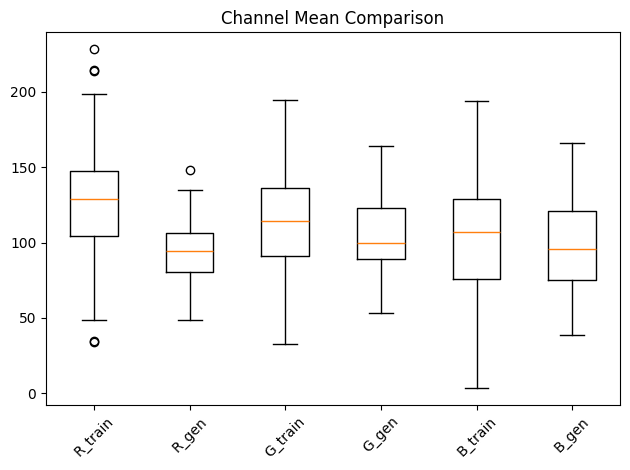

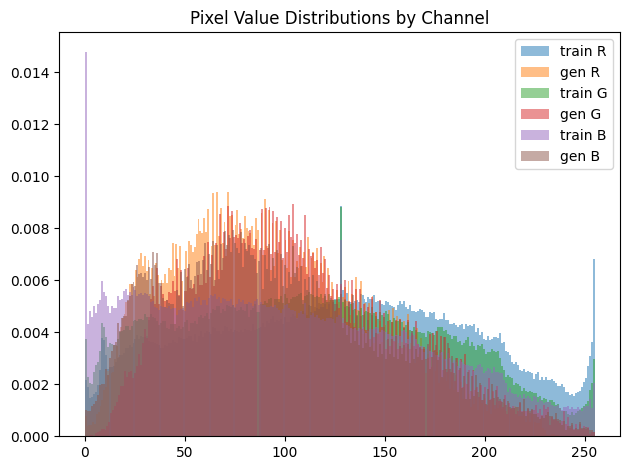

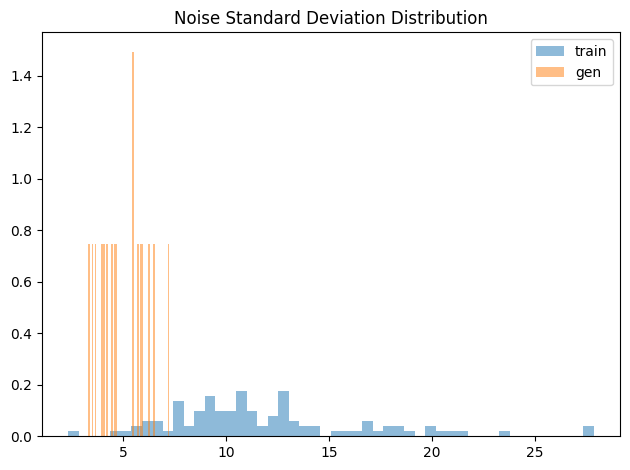

In [11]:
compare_images_stats('../Saved_Models/Unet_Logger_config_7/generated', '../Data/Raw/primary_data/cats/Data/', sample_size=100)